In [1]:
import bt
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sklearn
from ta.trend import ADXIndicator 
import scipy.stats as stats

In [234]:
aapl_data = yf.download(tickers = 'AAPL', start = '2017-01-01', end ='2024-09-30', interval = '1d')
meta_data = yf.download(tickers = 'META', start = '2017-01-01', end ='2024-09-30', interval = '1d')
backtest_data = aapl_data.copy()
backtest_data['Open'] = aapl_data['Adj Close']
backtest_data['High'] = meta_data['Adj Close']
backtest_data = backtest_data.drop(['Low','Close','Adj Close','Volume'], axis = 1)
backtest_data = backtest_data.rename(columns = {'Open' : 'AAPL', 'High' : 'META'})
backtest_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,META
Date,,
2017-01-03,26.921545,116.509209
2017-01-04,26.891413,118.333710
2017-01-05,27.028168,120.307770
2017-01-06,27.329485,123.039543
2017-01-09,27.579803,124.525070
...,...,...
2024-09-23,226.470001,564.409973
2024-09-24,227.369995,563.330017
2024-09-25,226.369995,568.309998


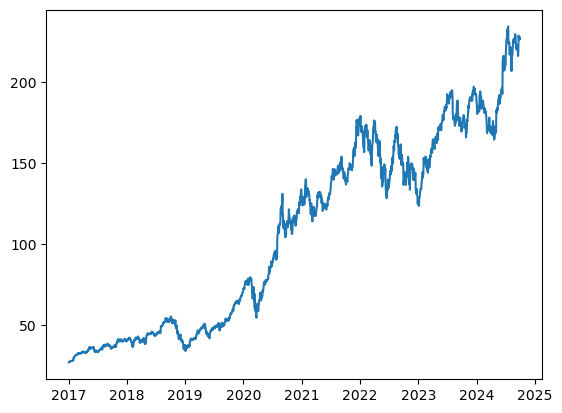

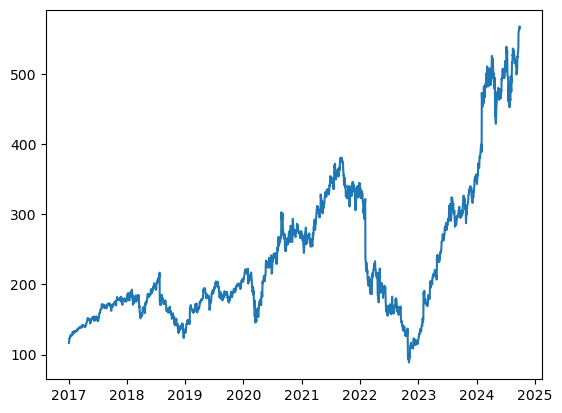

In [235]:
plt.plot(backtest_data['AAPL'])
plt.show()
plt.plot(backtest_data['META'])
plt.show()

In [236]:

change = backtest_data.diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()
change_up[change_up<0] = 0
change_down[change_down>0] = 0

avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

RSI = 100 * avg_up / (avg_up + avg_down)

# SMA
sma_10 = backtest_data.rolling(10).mean()
sma_20 = backtest_data.rolling(20).mean()
sma_50 = backtest_data.rolling(50).mean()
sma_200 = backtest_data.rolling(200).mean()
sma_24 = backtest_data.rolling(24).mean()

# Bollinger band

upper_boll = sma_50 + 2*backtest_data.rolling(window=50).std()
lower_boll = sma_50 - 2*backtest_data.rolling(window=50).std()

upper_boll_1 = sma_24 + 2*backtest_data.rolling(window=24).std()
lower_boll_1 = sma_24 - 2*backtest_data.rolling(window=24).std()

upper_boll_2 = sma_24 + 1*backtest_data.rolling(window=24).std()
lower_boll_2 = sma_24 - 1*backtest_data.rolling(window=24).std()


# MACD
ema12 = backtest_data.ewm(span = 12, adjust = False).mean()
ema26 = backtest_data.ewm(span = 26, adjust = False).mean()
MACD = ema12 - ema26
signal_line = backtest_data.ewm(span=9, adjust = False).mean()

RSI.fillna(50, inplace = True)


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


,,price,quantity
Date,Security,,
2017-06-12,AAPL,33.991692,294.0
2017-06-13,AAPL,34.265160,-294.0
2017-06-14,AAPL,33.930923,297.0
2017-06-19,AAPL,34.206738,-297.0
2017-09-21,AAPL,35.995461,282.0
...,...,...,...
2024-05-01,META,438.336212,-49.0
2024-07-17,META,461.549683,46.0
2024-07-18,META,475.396484,-46.0


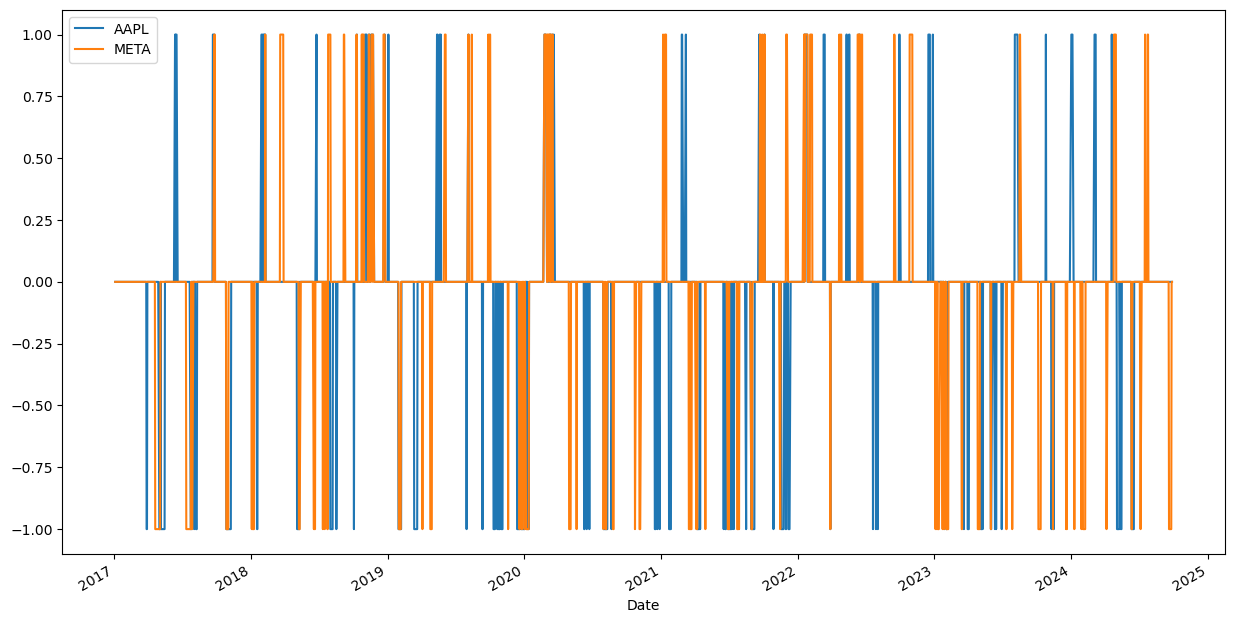

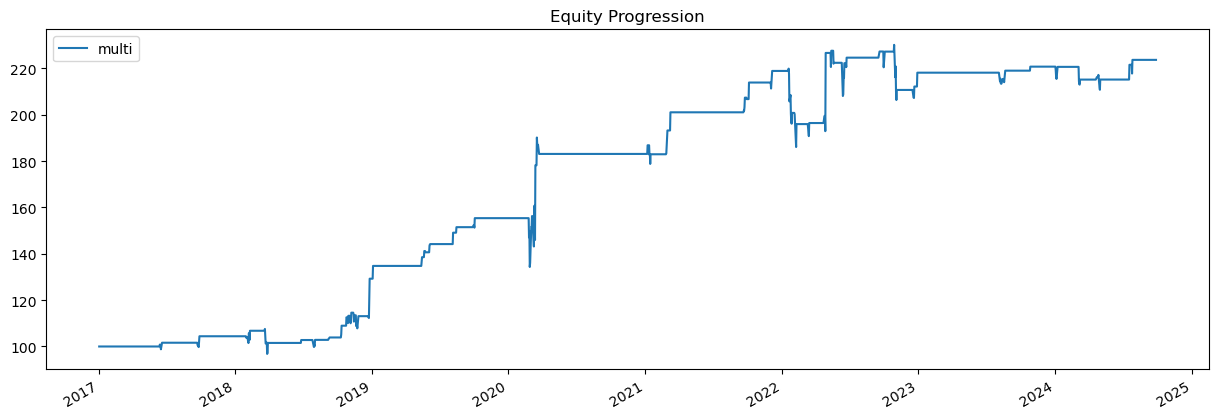

In [244]:

# Set the Moveing Averge window
window = 30

# Calculate the SMA with this Widnow
sma = backtest_data.rolling(window).mean()

# Calculate the Upper and Lower Bollinger bands
upper_boll_1 = sma + 2*backtest_data.rolling(window=window).std()
lower_boll_1 = sma - 2*backtest_data.rolling(window=window).std()

# Copy the structure of the stock data, mainly the date column
signal = backtest_data.copy()

# Set values in df to NaN
signal[:] = np.nan

# Buy signal when the price drops below the 2std lower bollinger line 
buy_condition = ((backtest_data < lower_boll_1))
signal[buy_condition] = True  # Buy signal (True)

# Sell signal when the price is above the 2std upper Bollinger line
sell_condition = ((backtest_data > upper_boll_1))
signal[sell_condition] = False

# Create the Weight allocation class 
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights, signal):
        self.tw = target_weights
        self.signal = signal
    
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.where(self.signal.loc[target.now], other=0)
            
            target.temp['weights'] = w.dropna()
    
        return True


# Produce the target weight df 
tw = backtest_data.copy()

# Set inital weights to 0
tw[:] = 0

# Set weight to 1.0 (long position) when the price is below the Lower bollinger line
tw[((backtest_data < lower_boll_1))] = 1.0

# Set weight to -1.0 (short position) when the price is above the Upper Bollinger line
tw[((backtest_data > upper_boll_1))] = -1.0

# Set the weight to 0.0 to exit both the long and short positions. We need to understand the logic here.
# When the signal is False we are in a short position and we want to exit when the price reverts downwards below the SMA.
# Similarly when the signal is True we are in a long position and we exit when the price reverts upwards above the SMA.
tw[((signal == False) & (backtest_data < sma)) | ((signal == True) & (backtest_data > sma))] = 0.0

# Plot the weighting of the stocks
ax = tw.plot(figsize = (15,8), secondary_y = ['tw'], legend = True)

# Produce the Strategy
s = bt.Strategy('multi', [bt.algos.RunDaily(),             # Run Daily
                          bt.algos.SelectAll(),            # Select all stocks
                          WeighTarget(tw,signal),          # Weight allocation
                          bt.algos.Rebalance()])           # Rebalance


# now we create the Backtest
t = bt.Backtest(s, backtest_data, initial_capital = 10000)
res = bt.run(t)
res.plot()
res.get_transactions()


In [246]:
res.display()


Stat                 multi
-------------------  ----------
Start                2017-01-02
End                  2024-09-27
Risk-free rate       0.00%

Total Return         123.67%
Daily Sharpe         0.67
Daily Sortino        1.32
CAGR                 10.97%
Max Drawdown         -15.38%
Calmar Ratio         0.71

MTD                  0.00%
3m                   3.95%
6m                   3.96%
YTD                  1.33%
1Y                   2.13%
3Y (ann.)            2.55%
5Y (ann.)            8.10%
10Y (ann.)           -
Since Incep. (ann.)  10.97%

Daily Sharpe         0.67
Daily Sortino        1.32
Daily Mean (ann.)    11.93%
Daily Vol (ann.)     17.81%
Daily Skew           7.50
Daily Kurt           145.21
Best Day             22.10%
Worst Day            -10.30%

Monthly Sharpe       0.70
Monthly Sortino      2.00
Monthly Mean (ann.)  11.80%
Monthly Vol (ann.)   16.87%
Monthly Skew         3.96
Monthly Kurt         25.86
Best Month           34.49%
Worst Month          -12.39%

Year

In [ ]:


# Buy signal when the prive drops below the 2std lower bollinger line OR we buy if the price is lower than the 
# 24day MA whilst it is a Sell sognal (= False). This is becasue we want to exit a short postion where we 
buy_condition = ((backtest_data < lower_boll_1) | ((signal == False) & (backtest_data < sma)))
signal[buy_condition] = True  # Buy signal (True)

# Sell signal when the price is above the 2std upper Bollinger line OR we sell if the price greater than the 24 day average
# and has been a buy signal. This is becasue we want to 
sell_condition = ((backtest_data > upper_boll_1) | ((signal == True) & (backtest_data > sma)))
signal[sell_condition] = False
